### QF600 Assignment 2

#### Part 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
data = pd.read_csv('Market_Portfolio.csv', index_col=0)
data.index = pd.to_datetime(data.index, format='%Y%m').to_period('M')
data.head()

,Market
Date,
2004-01,2.22
2004-02,1.46
2004-03,-1.23
2004-04,-1.75
2004-05,1.23


In [4]:
df = pd.read_csv('Industry_Portfolios.csv', index_col=0)
df.index = pd.to_datetime(df.index, format='%Y%m').to_period('M')
df.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
2004-01,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88
2004-02,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16
2004-03,-0.09,-1.15,-0.27,-0.13,-2.55,-2.07,0.29,-3.96,1.13,-0.63
2004-04,1.42,2.30,-0.17,2.52,-4.91,-0.48,-2.70,3.54,-3.55,-3.76
2004-05,-1.89,-1.64,1.61,0.39,4.85,-2.95,0.30,-0.42,1.28,1.86


CAPM: $R_i - R_f = \beta _i (R_m - R_f) + \alpha _i$

In [5]:
risk_free_rate = 0.13 # Data given is in percentage

y = df - risk_free_rate
x = data - risk_free_rate

x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
capm_result = results.params
capm_result.columns = df.columns

round(capm_result, 3)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
const,0.369,-0.416,0.16,0.502,-0.064,0.195,0.275,0.238,0.445,-0.387
Market,0.653,1.649,1.17,0.970,1.133,0.901,0.826,0.673,0.538,1.207


In [6]:
from sklearn.linear_model import LinearRegression

# Defining the risk-free rate per month as 0.13%
risk_free_rate = 0.13

# Calculate excess returns by subtracting the risk-free rate from the market and industry returns
data['Excess Market Return'] = data['Market'] - risk_free_rate
industry_portfolios_df_excess = df.copy()
industry_columns = industry_portfolios_df_excess.columns  # Excluding the 'Date' column

for col in industry_columns:
    industry_portfolios_df_excess[col] = industry_portfolios_df_excess[col] - risk_free_rate

# Prepare to run regressions for each industry portfolio
results = []

# Running regression: Regressing each industry's excess returns on the market's excess returns
for col in industry_columns:
    # Create regression model
    reg = LinearRegression()
    
    # Prepare data for regression
    X = data['Excess Market Return'].values.reshape(-1, 1)  # Independent variable (market excess returns)
    y = industry_portfolios_df_excess[col].values  # Dependent variable (industry excess returns)
    
    # Fit the model
    reg.fit(X, y)
    
    # Store the intercept (α) and slope (β)
    alpha = reg.intercept_
    beta = reg.coef_[0]
    
    # Append the results to a list
    results.append({'Industry': col, 'Alpha (Intercept)': alpha, 'Beta (Slope)': beta})

# Convert results to DataFrame for better display
results_df = pd.DataFrame(results)

round(results_df, 3)

,Industry,Alpha (Intercept),Beta (Slope)
0,NoDur,0.369,0.653
1,Durbl,-0.416,1.649
2,Manuf,0.160,1.170
3,Enrgy,0.502,0.970
4,HiTec,-0.064,1.133
5,Telcm,0.195,0.901
6,Shops,0.275,0.826
7,Hlth,0.238,0.673
8,Utils,0.445,0.538
9,Other,-0.387,1.207


Constant/y-intercept/$\alpha_i$: "pricing error"

Market/Gradient/$\beta_i$: expected risk-adjusted return per unit risk

Intercept (α): This represents the industry portfolio's return that cannot be explained by the market's excess returns. In other words, it's the component of the return that is independent of the market. A positive α suggests the portfolio may outperform the market on average (after accounting for market movements), while a negative α indicates underperformance.

Slope (β): This coefficient measures the sensitivity of the portfolio's excess returns to the market's excess returns. A β greater than 1 implies the portfolio is more volatile than the market (amplified reactions to market changes), while a β less than 1 suggests less sensitivity (the portfolio moves less in response to market movements).

#### Part 2

In [9]:
# Calculating the mean monthly return for each industry portfolio and the market portfolio
mean_industry_returns = df[industry_columns].mean()
mean_market_return = data['Market'].mean()

beta_values = results_df['Beta (Slope)']
mean_returns_df = pd.DataFrame({
    'Industry': industry_columns,
    'Mean Return': mean_industry_returns.values,
    'Beta': beta_values
})

# Adding the market portfolio information to this DataFrame
market_data = pd.DataFrame({
    'Industry': ['Market'],
    'Mean Return': [mean_market_return],
    'Beta': [1.0]  # Beta for the market portfolio is always 1
})

mean_returns_df = pd.concat([mean_returns_df, market_data], ignore_index=True)
round(mean_returns_df,3)

,Industry,Mean Return,Beta
0,NoDur,0.903,0.653
1,Durbl,0.733,1.649
2,Manuf,1.013,1.170
3,Enrgy,1.231,0.970
4,HiTec,0.766,1.133
5,Telcm,0.881,0.901
6,Shops,0.916,0.826
7,Hlth,0.784,0.673
8,Utils,0.907,0.538
9,Other,0.489,1.207


In [8]:
X_sml = mean_returns_df['Beta'].values.reshape(-1, 1) 
y_sml = mean_returns_df['Mean Return'].values

sml_reg = LinearRegression()
sml_reg.fit(X_sml, y_sml)
sml_intercept = sml_reg.intercept_
sml_slope = sml_reg.coef_[0]

print(sml_intercept, sml_slope)

1.0327683682657058 -0.18546745836573267


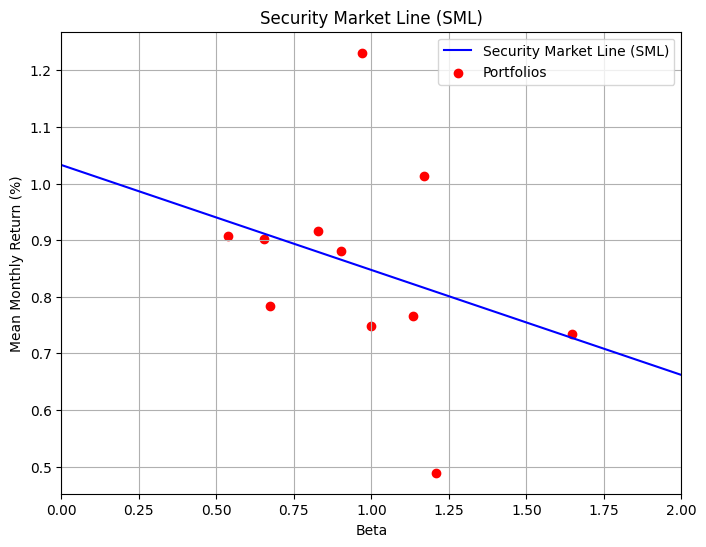

In [76]:
beta_range = np.linspace(0, 2, 100)
sml_line = sml_intercept + sml_slope * beta_range

plt.figure(figsize=(8, 6))
plt.plot(beta_range, sml_line, label='Security Market Line (SML)', color='blue')
plt.scatter(mean_returns_df['Beta'], mean_returns_df['Mean Return'], color='red', label='Portfolios')

plt.title('Security Market Line (SML)')
plt.xlabel('Beta')
plt.ylabel('Mean Monthly Return (%)')
plt.xlim(0, 2)
plt.legend()
plt.grid(True)
plt.show()

Security Market Line (SML): The SML represents the relationship between risk (measured by beta) and expected return in the Capital Asset Pricing Model (CAPM). According to CAPM, an asset's expected return is determined by its beta, with higher beta portfolios offering higher returns to compensate for greater risk.

Intercept: The intercept of the SML is the risk-free rate, which represents the return on an investment with no risk (in this case, assumed at 0.13% per month).

Slope: The slope of the SML reflects the market risk premium, which is the additional return investors require for taking on market risk as opposed to risk-free investments. A steeper slope would indicate a larger premium for taking on risk.

In pricing terms, portfolios that lie above the SML are considered underpriced because they offer higher returns for their level of risk, while portfolios below the SML are overpriced because they offer lower returns for their level of risk.

Here are a few possible reasons why the slope of the SML might turn out negative:
1. Data Anomalies or Short-term Market Conditions:

    The period used for the analysis (2004-2013) may reflect unusual market conditions, such as a significant market downturn (e.g., the 2008 financial crisis) that disproportionately impacted high-beta stocks, causing them to have lower returns despite higher risk.
    If the dataset includes anomalies like this, high-beta portfolios could perform worse, thus leading to a negative relationship between risk (beta) and returns.

2. Measurement or Model Errors:

    There could be issues with the data itself, such as missing or inconsistent returns, that distort the relationship between beta and returns.
    Alternatively, the estimation of betas could be influenced by a short or noisy sample period, leading to less reliable results.

3. Mean Reversion or Market Behavior:

    A negative slope could imply that during the selected period, lower-beta (less risky) portfolios actually outperformed higher-beta (riskier) ones. This might happen in periods of extreme market volatility, where investors seek safer, low-risk investments, driving their returns higher.
    In some cases, a "flight to quality" occurs, where investors flock to safer investments, which can push up the prices (and hence the returns) of low-beta assets.

4. Temporary Pricing Inefficiencies:

    If markets are not fully efficient during the selected period, it is possible that the pricing of risk was distorted. For example, during periods of economic crisis or uncertainty, high-beta stocks might not be adequately compensated for their risk, resulting in lower returns.

5. Short-term Versus Long-term Horizon:

    CAPM is typically understood as a long-term model. Over shorter periods, market anomalies can occur, which might lead to unexpected patterns like a negative SML slope.

In summary, the negative SML slope suggests that, during the period under consideration, higher-beta portfolios offered lower returns, which is inconsistent with CAPM under normal conditions. This could be due to specific market conditions, anomalies in the data, or a reflection of short-term investor behavior.